## Imports

In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import os
os.environ['XLA_FLAGS'] = "--xla_disable_hlo_passes=constant_folding"
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np
from jax_tqdm import scan_tqdm
from jaxopt import GaussNewton, LevenbergMarquardt
from sbs import sbs
import matplotlib as mpl
from matplotlib.colors import LogNorm
mpl.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

## Check CUDA devs

In [136]:
jax.devices()

[CudaDevice(id=0)]

In [137]:
jax.devices()[0]

CudaDevice(id=0)

In [138]:
jax.devices()[0].memory_stats()

{'num_allocs': 24361,
 'bytes_in_use': 4037632,
 'peak_bytes_in_use': 88957391872,
 'largest_alloc_size': 88946937856,
 'bytes_limit': 112516399104,
 'bytes_reserved': 0,
 'peak_bytes_reserved': 0,
 'largest_free_block_bytes': 0,
 'pool_bytes': 112516399104,
 'peak_pool_bytes': 112516399104}

## Declare circuit parameters

In [139]:
N = 120
T = 40

t_sqg = 56 #ns
t_reset = 100 #ns

In [140]:
linear_betas = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["betas"][7:]

In [141]:
linear_delays = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["total_ecd_times"][7:]

In [142]:
p = jnp.polyfit(linear_betas, linear_delays, 1)

## Sweep circuit parameters

In [177]:
delta = 0.43
sd_ratio = 1.6
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
vac = jqt.basis(2, 0) ^ jqt.basis(N, 0)
plus_Z = jqt.basis(2, 0) ^ gkp_qubit.basis["-x"]
initial_state = plus_Z

logical_Z = gkp_qubit.common_gates["X_0"]
freq_res = 4.138e9
freq_qb = 233e6
k_B = 1.380649e-23
h = 6.62607015e-34
T_res = 40e-3
T_qb = 40e-3
n_bar_qb = 1/(jnp.exp(h*freq_qb/k_B/T_qb)-1)
n_bar_res = 1/(jnp.exp(h*freq_res/k_B/T_res)-1)
error_channels = {
    "resonator": {
        "selfkerr": 0,
        "chi": 31.7e-6*2*jnp.pi,
        "T1": 89e3,
        "Tphi": 65e3*1e6,
        "n_bar": n_bar_res,
    },
    "fluxonium": {
        "T1": 93e3,
        "Tphi": 7e3,
        "n_bar": n_bar_qb,
        "reset_p_eg": 0.0783e-100,
        "reset_p_ee": 0.0783e-100,
        "t_rst": t_reset
    }
}
error_channels_best_case = {
    "resonator": {
        "selfkerr": 0,
        "chi": 31.7e-6*2*jnp.pi,
        "T1": 120e3,
        "Tphi": 65e3*1e6,
        "n_bar": n_bar_res,
    },
    "fluxonium": {
        "T1": 1000e3,
        "Tphi": 500e3,
        "n_bar": n_bar_qb,
        "reset_p_eg": 0.01,
        "reset_p_ee": 0.01,
        "t_rst": t_reset
    }
}

In [178]:
def fit_t1(times, amps, guess):
    def exponential(x, x_data, y_data):
        return y_data-x[0]*jnp.exp(x[1]*x_data)
    gn = GaussNewton(residual_fun=exponential, tol=1e-9, maxiter=1000)
    gn_sol = gn.run(guess, x_data=times, y_data=amps)
    return gn_sol.params, gn_sol.state.error

In [179]:
def fit_t1_robust(times, amps):
    """
    Robustly fits y = A * exp(k * t) across both linear and exponential regimes.
    
    Strategy:
    1. Use linear regression (Taylor expansion) to generate a high-quality guess.
    2. Use Levenberg-Marquardt to refine the fit (handles ill-conditioned linear regimes better than GN).
    """

    # --- PHASE 1: Generate Smart Initialization ---
    # We approximate y ~ A(1 + kt) = A + (Ak)t
    # This gives us a closed-form guess without needing user input.
    coeffs = jnp.polyfit(times, amps, 1) # [slope, intercept]
    
    guess_A = coeffs[1]
    # Guard against divide by zero if intercept is 0
    guess_k = coeffs[0] / jnp.where(jnp.abs(guess_A) < 1e-9, 1.0, guess_A)
    
    initial_guess = jnp.array([guess_A, guess_k])

    # --- PHASE 2: Non-Linear Optimization ---
    def residual_fun(p, x_data, y_data):
        A, k = p
        return y_data - A * jnp.exp(k * x_data)

    # LevenbergMarquardt is preferred over GaussNewton here.
    # It adds a damping factor that stabilizes the fit when the curve 
    # looks like a line (singular Jacobian).
    lm = LevenbergMarquardt(residual_fun=residual_fun, tol=1e-7, maxiter=1000)
    
    # We use our smart guess to initialize the solver
    sol = lm.run(initial_guess, x_data=times, y_data=amps)
    
    return sol.params, sol.state.error

In [188]:
def comp_t1(delta, sd_ratio):
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
    plus_Z = jqt.basis(2, 0) ^ gkp_qubit.basis["-x"]
    initial_state = plus_Z
    speedup = 2
    ts, res = sbs(initial_state = initial_state,
            delta=delta,
            sd_ratio=sd_ratio,
            T=T,
            observable=logical_Z,
            t_sqg = t_sqg,
            t_CD_floor = linear_delays[0],
            t_CD_p = p,
            t_rst=t_reset,
            error_channels=error_channels_best_case,
            speedup=speedup
            )
    fit_res = fit_t1_robust(ts, jnp.abs(res))
    coeff = fit_res[0]
    residuals = fit_res[1]
    t1 = -1/coeff[1]
    return t1, res, ts, coeff, residuals

In [189]:
deltas = jnp.linspace(0.20, 0.4, 15)
sd_ratios = jnp.linspace(2, 5, 8)
deltas_mg, sd_ratios_mg = jnp.meshgrid(deltas, sd_ratios)
#speedup = jnp.array([1, 2, 3, 4, 5])
#qubit_t2 = jnp.array([1, 2, 5, 10, 20, 50, 100]) * 7e3

In [190]:
vm_t1 = jax.jit(jax.vmap(jax.vmap(comp_t1, in_axes=(0, 0), out_axes=(0, 0, 0, 0, 0)), in_axes=(0, 0), out_axes=(0, 0, 0, 0, 0)))

In [191]:
t1, res, ts, coeff, residuals = vm_t1(deltas_mg, sd_ratios_mg)

In [192]:
t1 = t1/1e3

In [193]:
max_t1_idx = np.unravel_index(np.nanargmax(t1), t1.shape)
max_t1 = t1[max_t1_idx]
max_t1_delta = deltas_mg[max_t1_idx]
max_t1_sd_ratio = sd_ratios_mg[max_t1_idx]

In [194]:
t1 = jnp.where(t1 < 0, jnp.nan, t1)

Text(0.5, 1.0, 'Logical lifetime')

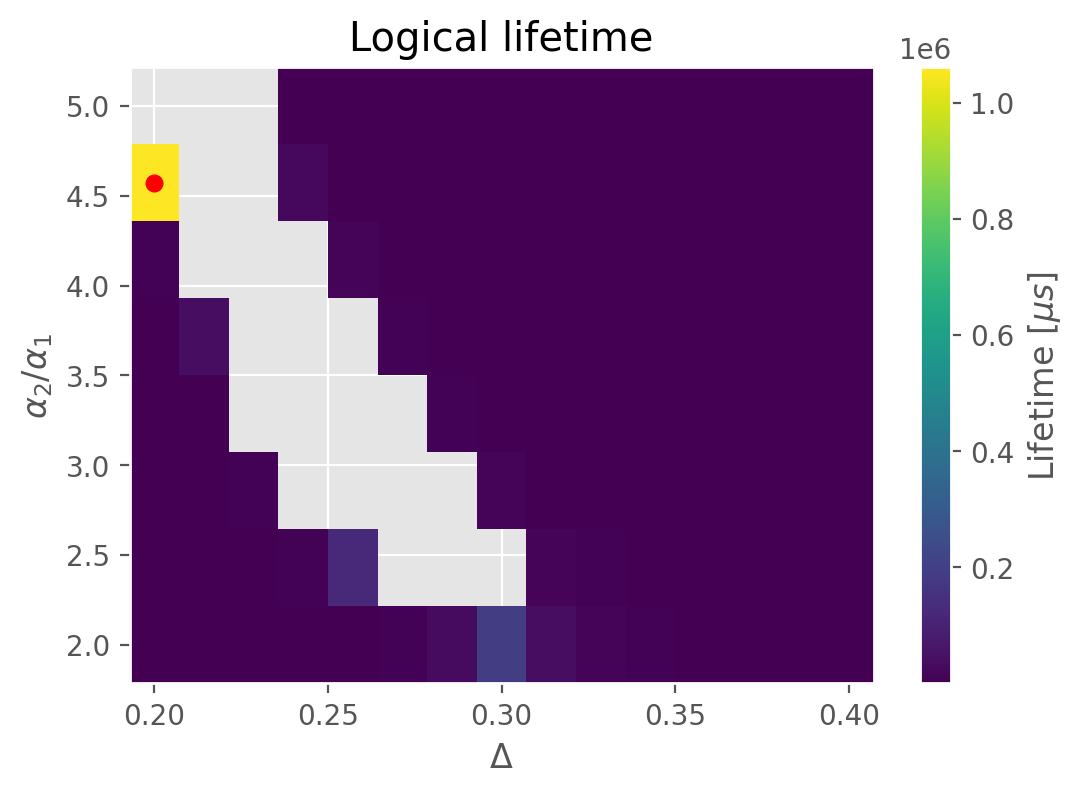

In [195]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=200)
handle = ax.pcolormesh(deltas_mg, sd_ratios_mg, t1, shading='nearest')#, norm=LogNorm(vmin=jnp.nanmin(t1), vmax=jnp.nanmax(t1)))
fig.colorbar(handle, ax=ax, label="Lifetime $[\mu s]$")
ax.scatter(max_t1_delta, max_t1_sd_ratio, color='red')
ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$\alpha_2 / \alpha_1$")
ax.set_title(f"Logical lifetime")

In [196]:
res.shape

(8, 15, 41)

In [ ]:
coeff

In [ ]:
res.shape

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


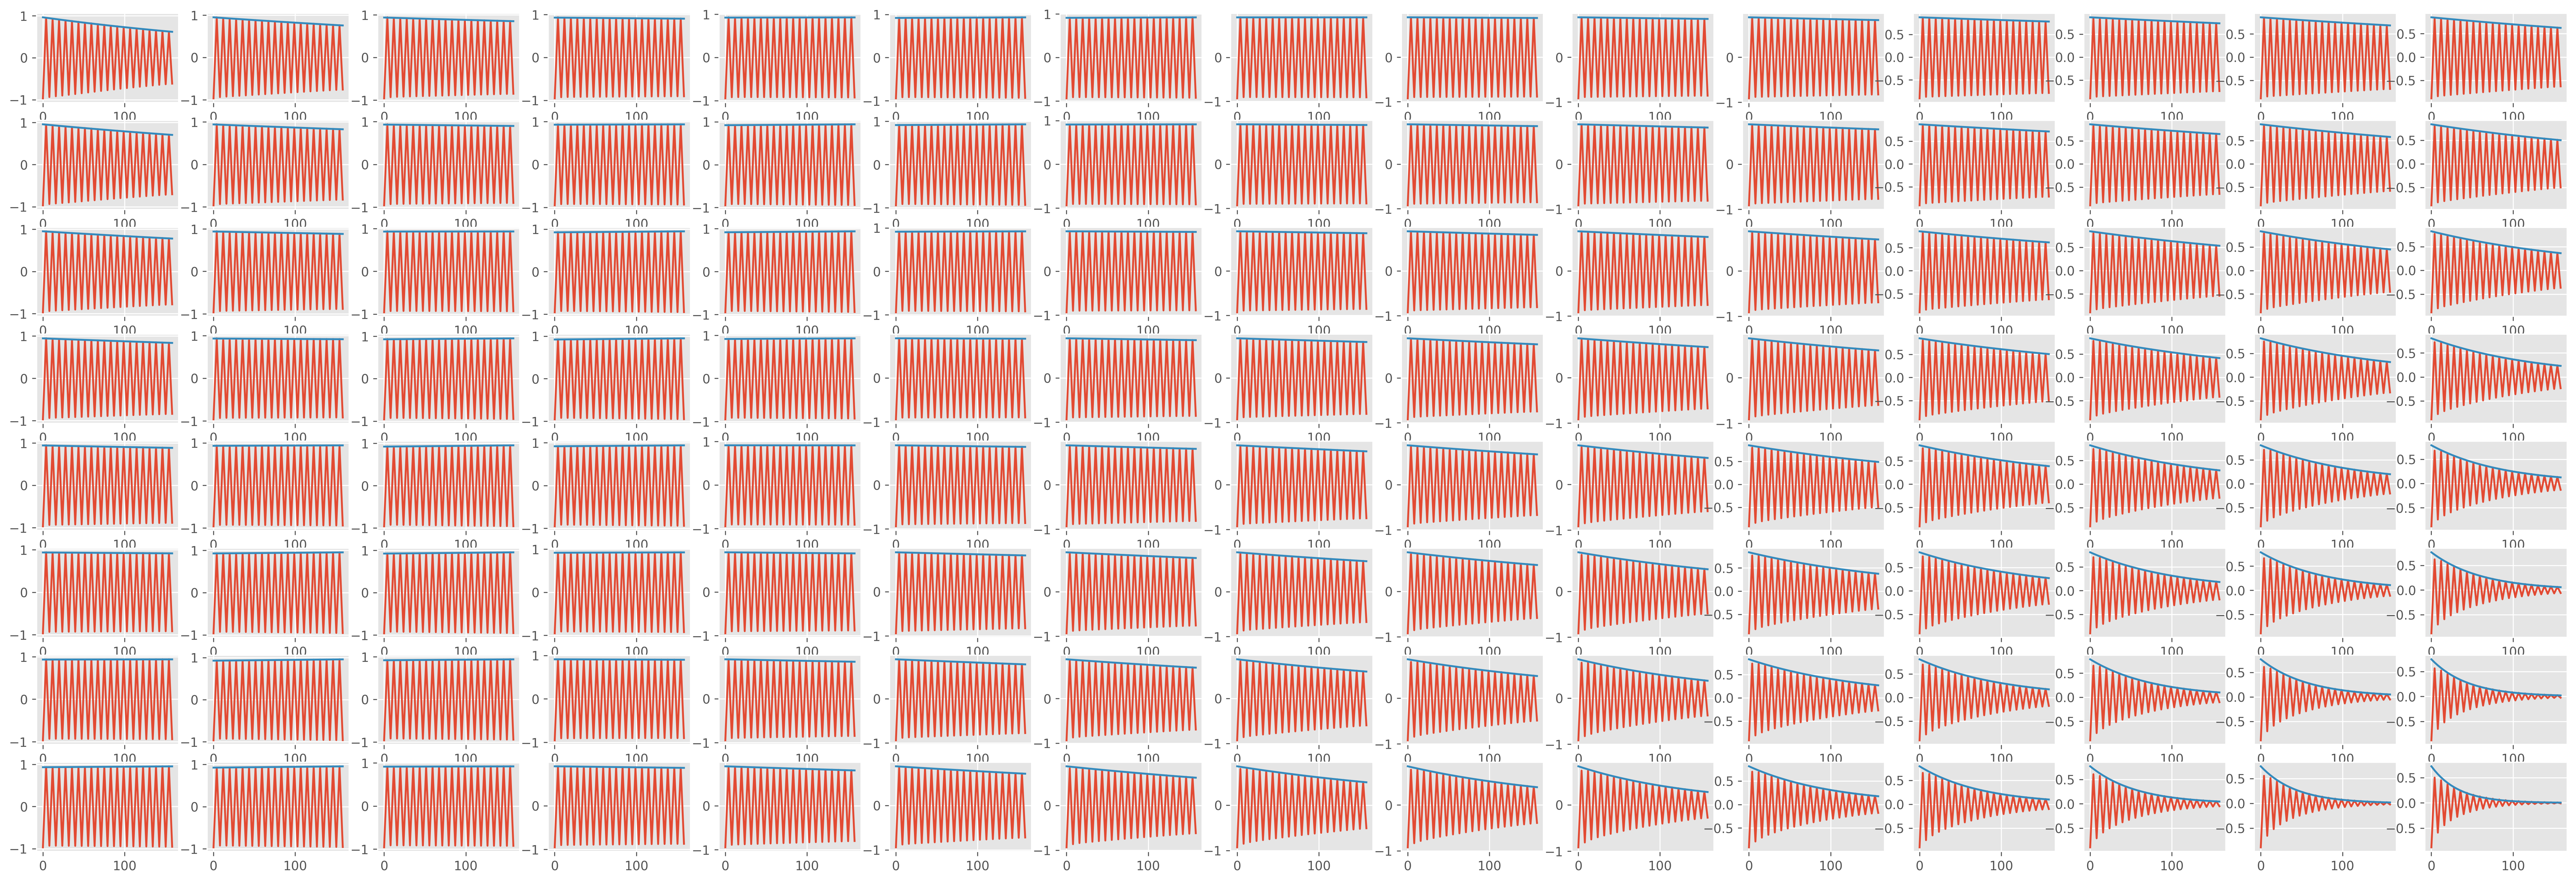

In [154]:
fig, axs = plt.subplots(*res.shape[:2], figsize=(36, 12))
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        axs[i, j].plot(ts.squeeze()[i, j]/1e3, res[i, j])
        fit = coeff.squeeze()[i, j, 0]*jnp.exp(coeff.squeeze()[i, j, 1]*ts.squeeze()[i, j])
        axs[i, j].plot(ts[i, j]/1e3, fit)

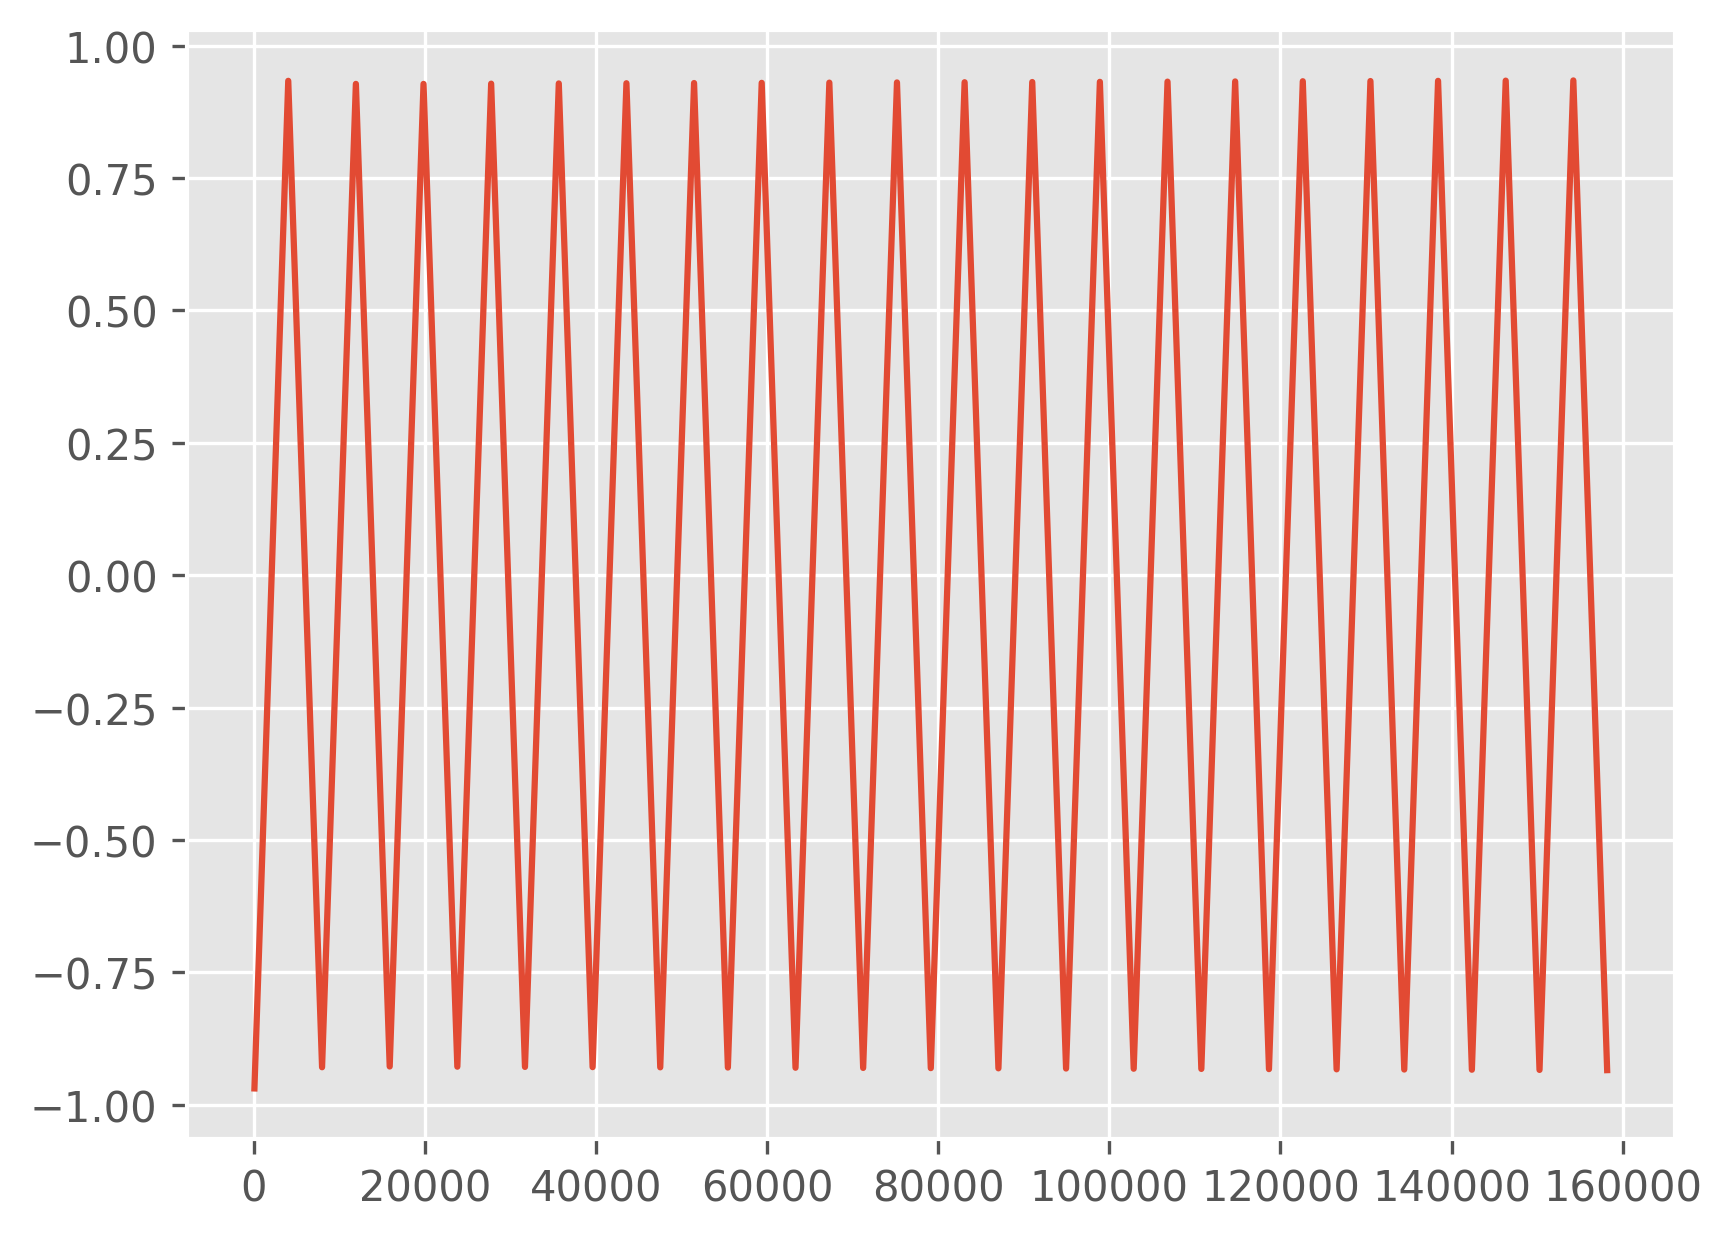

In [109]:
plt.plot(ts[7, 0], res[7, 0])

In [42]:
n = 17
jnp.abs(jnp.real(res[max_t1_idx][n]))-jnp.abs(jnp.real(res[max_t1_idx][n+1]))

Array(1.4075535e-05, dtype=float64)

In [178]:
max_t1_idx

(np.int64(5), np.int64(0))

In [203]:
temp_ts = ts[6, 0]
temp_res = res[6, 0]

In [204]:
def fit_t1_linear_limit(times, amps, guess=None):
    """
    Fits an exponential in the short-time limit where the decay looks linear.
    Uses a 1st order Taylor expansion: A * exp(kt) ~ A + A*k*t
    
    Args:
        times: Array of time points.
        amps: Array of amplitude points.
        guess: Unused in this method (linear least squares has a closed-form solution).
        
    Returns:
        params: jnp.array([Amplitude, Rate])
        error: Sum of squared residuals
    """
    # 1. Fit a first-degree polynomial (Line: y = slope*t + intercept)
    # This returns [slope, intercept]
    coeffs = jnp.polyfit(times, amps, 1)
    slope = coeffs[0]
    intercept = coeffs[1]

    # 2. Map linear parameters back to exponential parameters
    # Intercept ~ Amplitude (A)
    # Slope ~ A * k  ->  k = Slope / A
    fitted_A = intercept
    fitted_k = slope / intercept

    params = jnp.array([fitted_A, fitted_k])

    # 3. Calculate error (Loss)
    # Recomputing the residual sum of squares to match the original return signature
    # Note: We compute error against the linear model, as that is what we fit.
    prediction = intercept + slope * times
    residuals = amps - prediction
    error = 0.5 * jnp.sum(residuals**2)

    return params, error

In [205]:
temp_fit_res = fit_t1_linear_limit(temp_ts, jnp.abs(temp_res))
temp_coeff = temp_fit_res[0]
temp_residuals = temp_fit_res[1]
temp_t1 = -1/temp_coeff[1]

In [206]:
temp_t1/1e3

Array(-16290.43725166, dtype=float64)

In [55]:
cut_temp_res = temp_res[40:]
cut_temp_ts = temp_ts[40:]

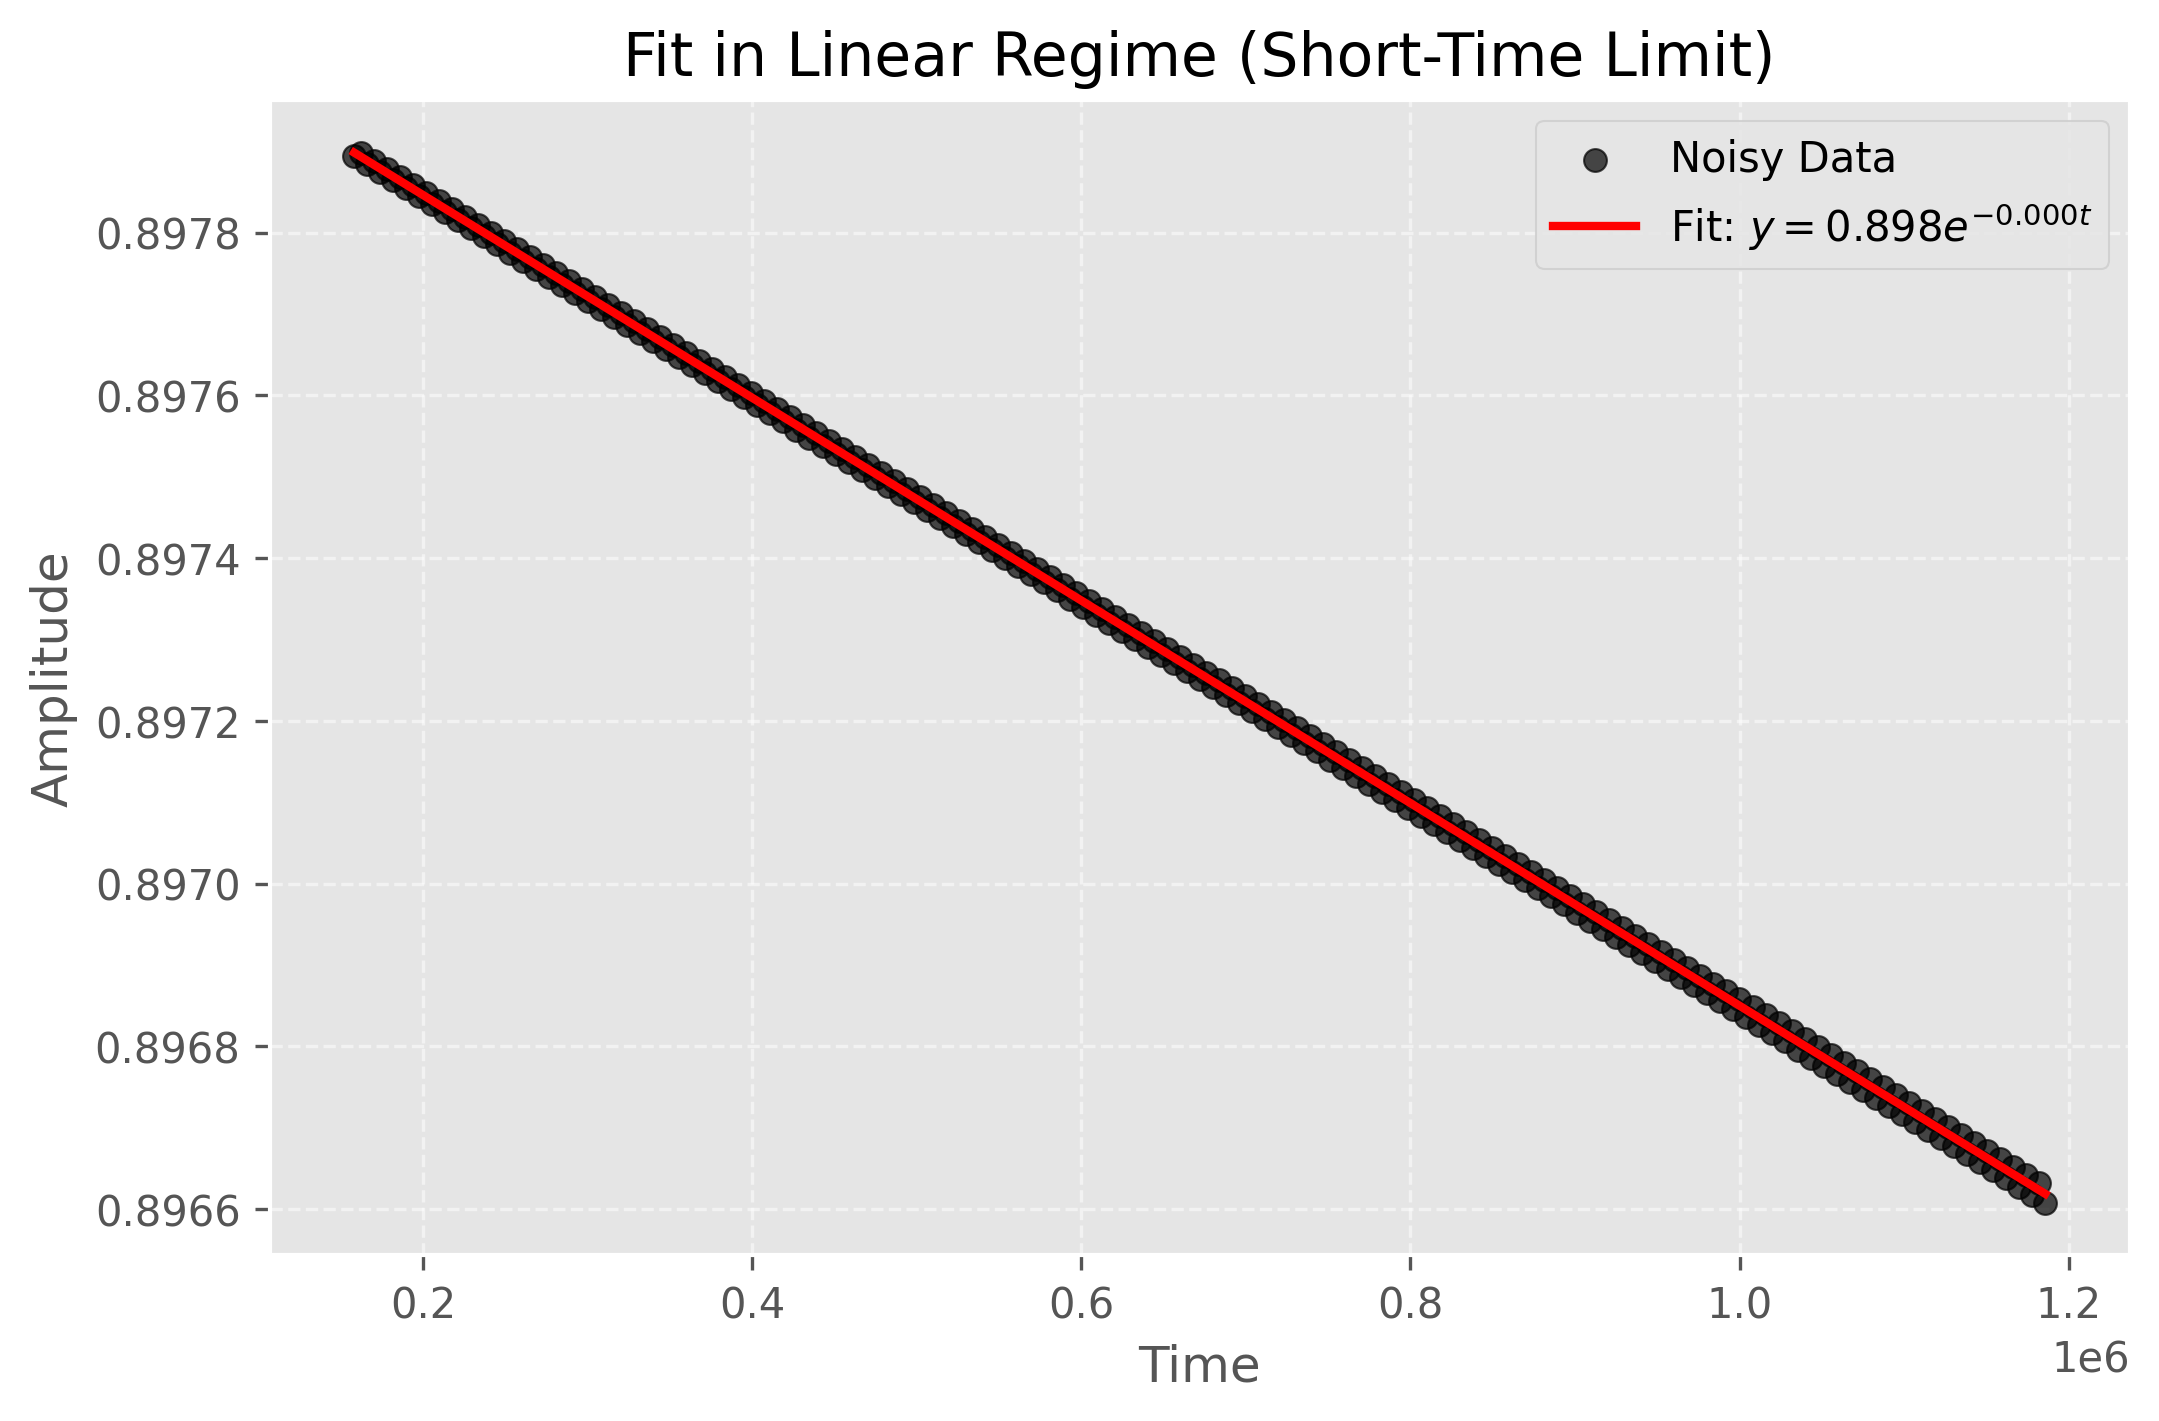

In [56]:
# 2. Run the Fit
# (Assumes fit_t1_linear_limit is defined as in the previous step)
params, error = fit_t1_linear_limit(cut_temp_ts, jnp.abs(cut_temp_res))
A_fit, k_fit = params

# 3. Calculate the curve for plotting
# We plot the full exponential model using the fitted parameters
fit_curve = A_fit * jnp.exp(k_fit * cut_temp_ts)

# 4. Plot
plt.figure(figsize=(8, 5))
plt.scatter(cut_temp_ts, jnp.abs(cut_temp_res), color='black', s=30, label='Noisy Data', alpha=0.7)
plt.plot(cut_temp_ts, fit_curve, color='red', linewidth=2, label=f'Fit: $y={A_fit:.3f} e^{{{k_fit:.3f} t}}$')

# Formatting
plt.title("Fit in Linear Regime (Short-Time Limit)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [58]:
-1/k_fit

Array(7.20704747e+08, dtype=float64)